In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flow_policy.flow_policy import FlowPolicy
from flow_policy.plot import (
    plot_probability_density_and_vector_field,
    plot_probability_density_and_streamlines,
    plot_probability_density_with_trajectories,
)

from pydrake.all import (
    PiecewisePolynomial,
    Trajectory,
)

# Set seed
np.random.seed(0)

In [2]:
def demonstration_traj_right() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.75, 0.00, -0.75, 0.00]],
        sample_dot_at_start=[[3.0]],
        sample_dot_at_end=[[3.0]],
    )

def demonstration_traj_left() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.75, 0.00, 0.75, 0.00]],
        sample_dot_at_start=[[-3.0]],
        sample_dot_at_end=[[-3.0]],
    )

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

## Plot demonstration trajectories

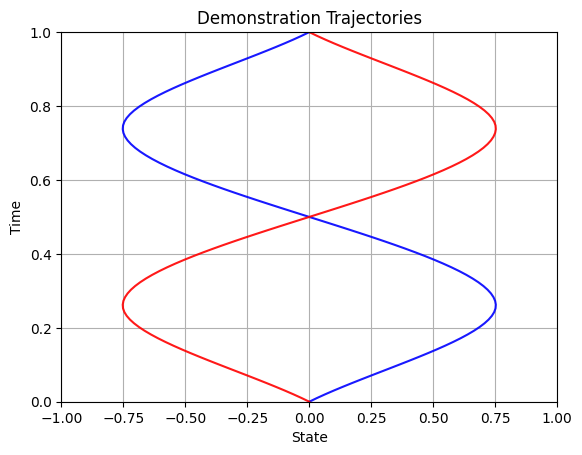

In [3]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

# Marginal flow

In [4]:
fp = FlowPolicy(trajectories=[traj_right, traj_left], prior=[0.5, 0.5], sigma=0.05)

## Plot marginal probability path

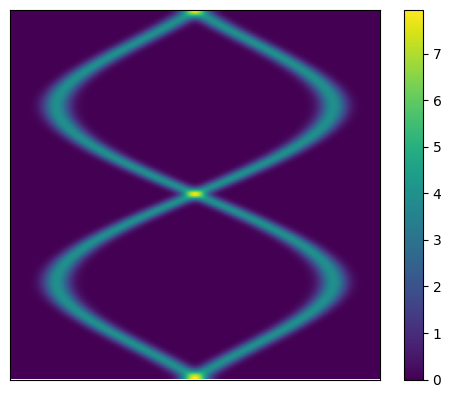

In [5]:
ts = np.linspace(0, 1, 200)  # (T,)
xs = np.linspace(-1, 1, 200)  # (X,)
ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
p = fp.pdf_marginal(xs, ts)  # (T, X)
plt.imshow(p, origin='lower')
plt.colorbar()
plt.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
# plt.tight_layout()
plt.show()


## Plot marginal vector field

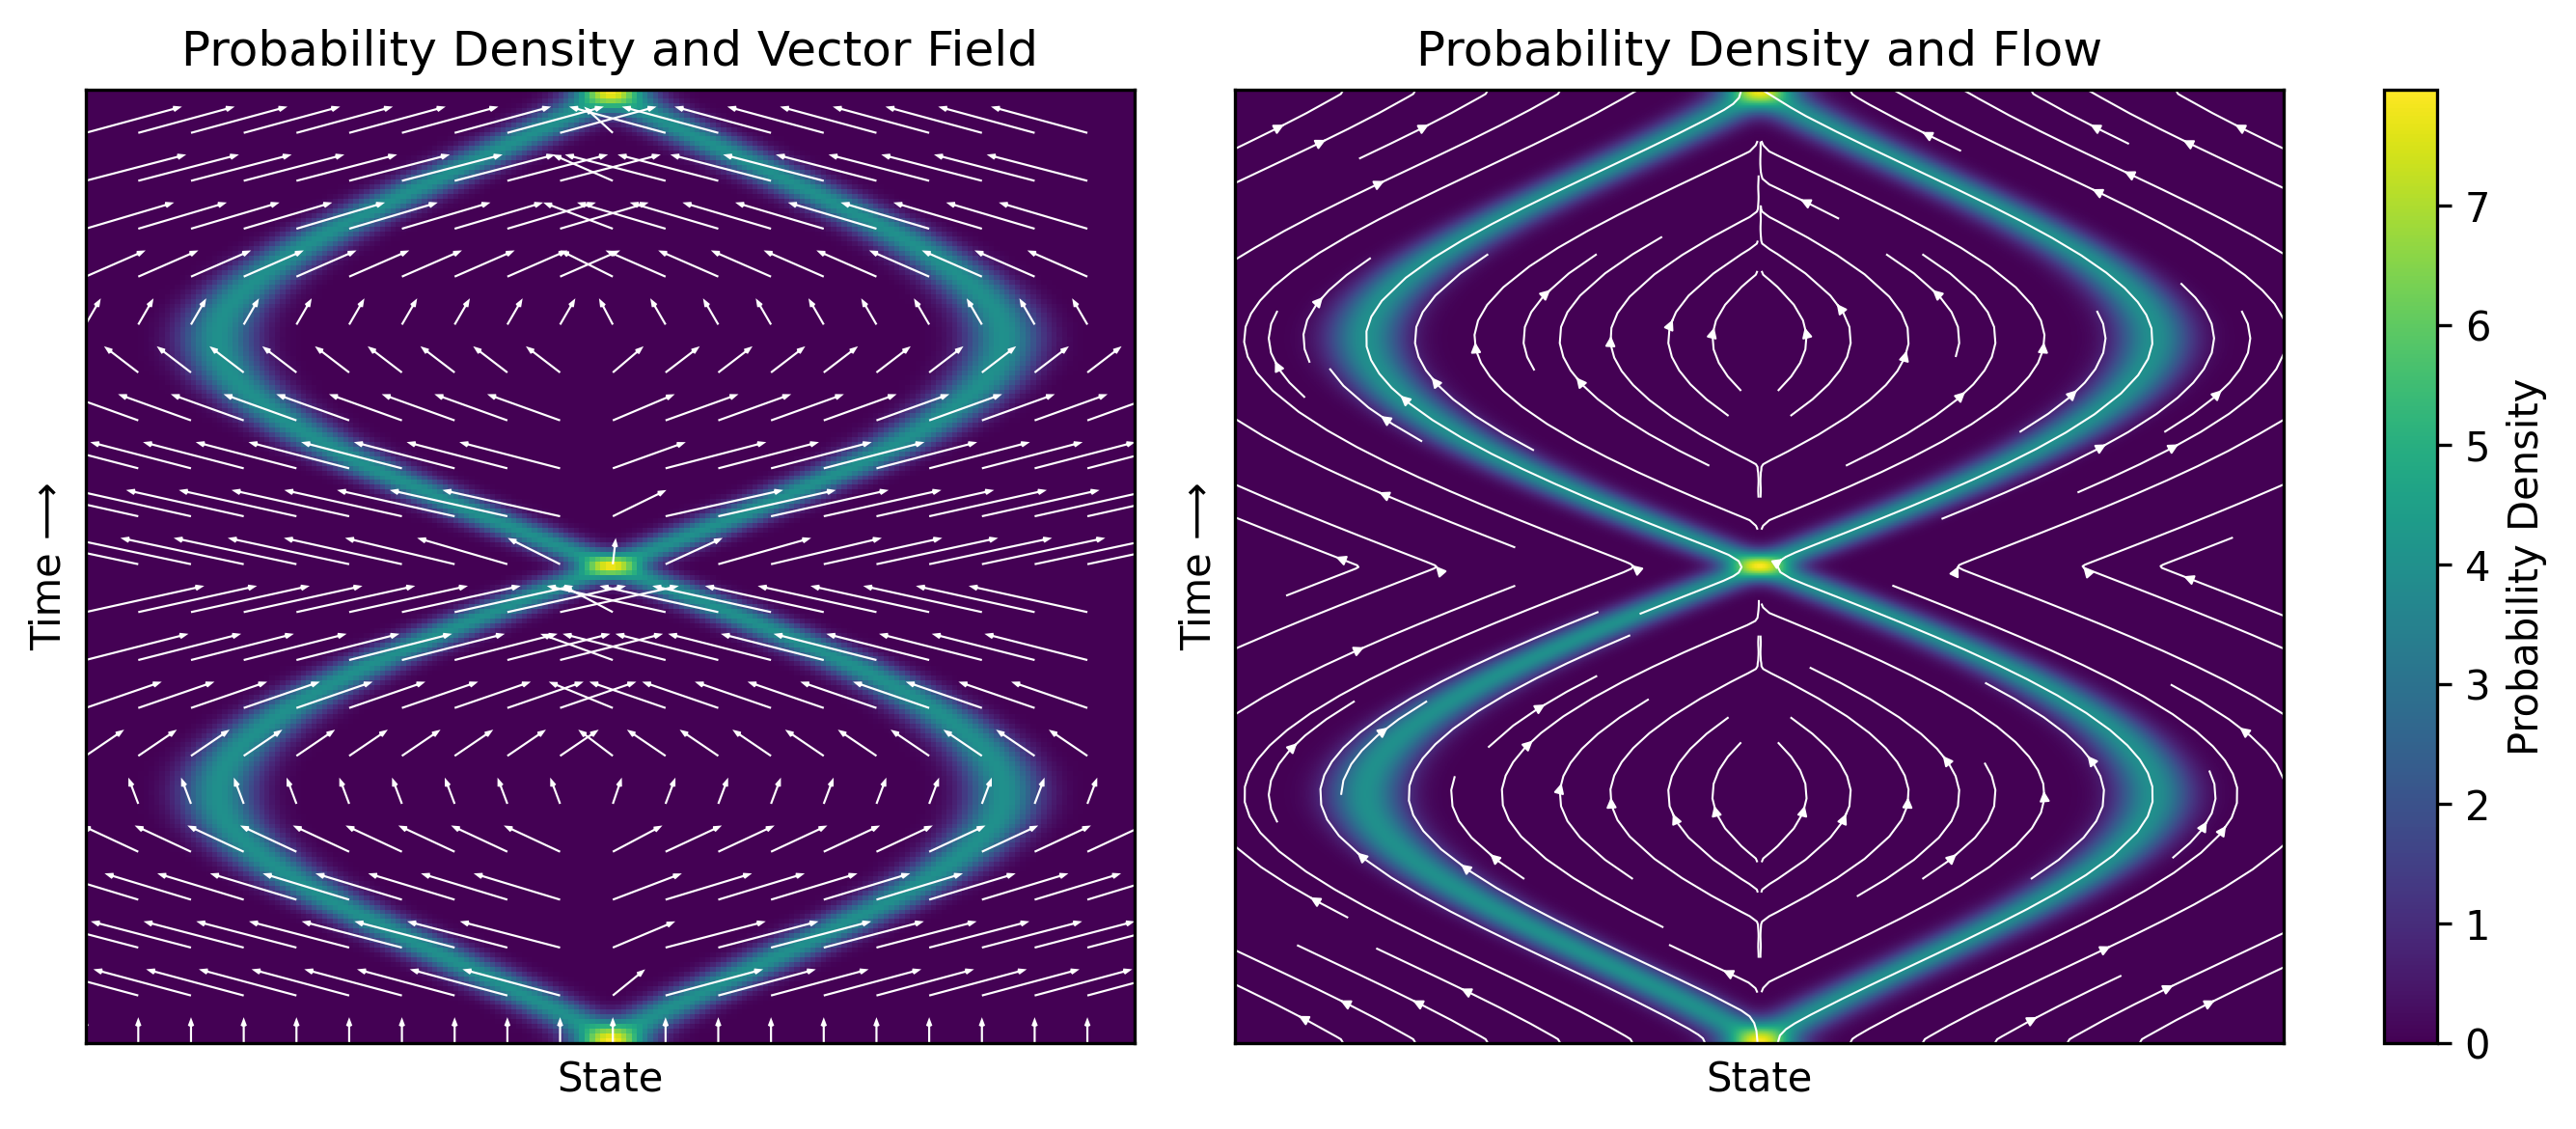

In [6]:
fig = plt.figure(figsize=(9, 4), dpi=300)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
im1 = plot_probability_density_and_vector_field(fp, ax1)
im2 = plot_probability_density_and_streamlines(fp, ax2)
plt.colorbar(im2, cax=ax3, label='Probability Density')
plt.tight_layout()  # Uncommented to adjust spacing
plt.show()

## Plot trajectories under marginal flow

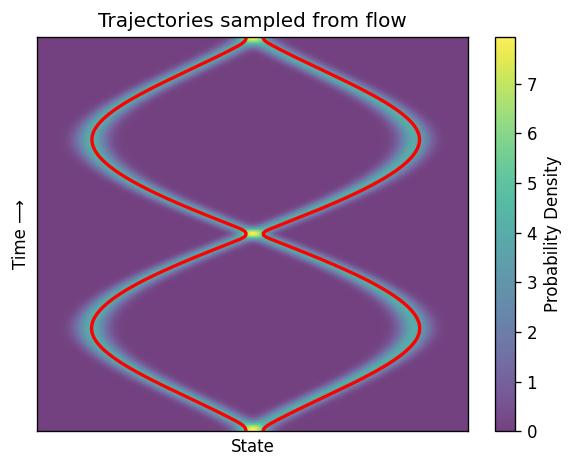

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
im = plot_probability_density_with_trajectories(
    fp, ax, xs_start=[-0.03, 0.05], linewidth=2, alpha=1, heatmap_alpha=0.75,
)
plt.colorbar(im, ax=ax, label='Probability Density')
plt.tight_layout()
plt.show()

The sampled trajectories have **<u>4 modes</u>** instead of the 2 modes in the training distribution!
- The above sampled trajectories do not belong to the distribution of training trajectories.
  - However the marginal proabilities at each time match the training distribution; this is guaranteed by flow matching!
- Is this a good thing or a bad thing?
  - It is bad if fidelity of the sampled path is important.
  - However, I would argue that for robotics, when trajectories are interpreted as positions, it is a **good** thing! If the two demonstration trajectories are valid, then these sampled trajectories should also be valid. Another way to look at it is that the flow policy approach provides **<u>compositionality</u>** over the demonstrations. With few demonstrations, the flow model is able to sample many valid combinations of partial trajectories.